# PS reconstruction, Gaussian beam, t scan study

In [1]:
import os
import torch
import numpy as np
import matplotlib.pyplot as plt

from phase_space_reconstruction.virtual.beamlines import quadlet_tdc_bend
from phase_space_reconstruction.virtual.scans import run_awa_t_scan
from phase_space_reconstruction.diagnostics import ImageDiagnostic
from phase_space_reconstruction.visualization import plot_3d_scan_data
from phase_space_reconstruction.train import train_3d_scan, train_3d_scan_parallel_gpus

from bmadx.distgen_utils import create_beam
from bmadx.plot import plot_projections
from bmadx.constants import PI

## Create synthetic ground truth beam

In [2]:
# create synthetic ground truth beam from base and transform yaml files
save_dir = os.path.join('data', 'gaussian_beam', 't_scan')
p0c = 43.36e6 # reference momentum in eV/c

gt_beam = torch.load("data/gaussian_beam_w_E_corr.pt")

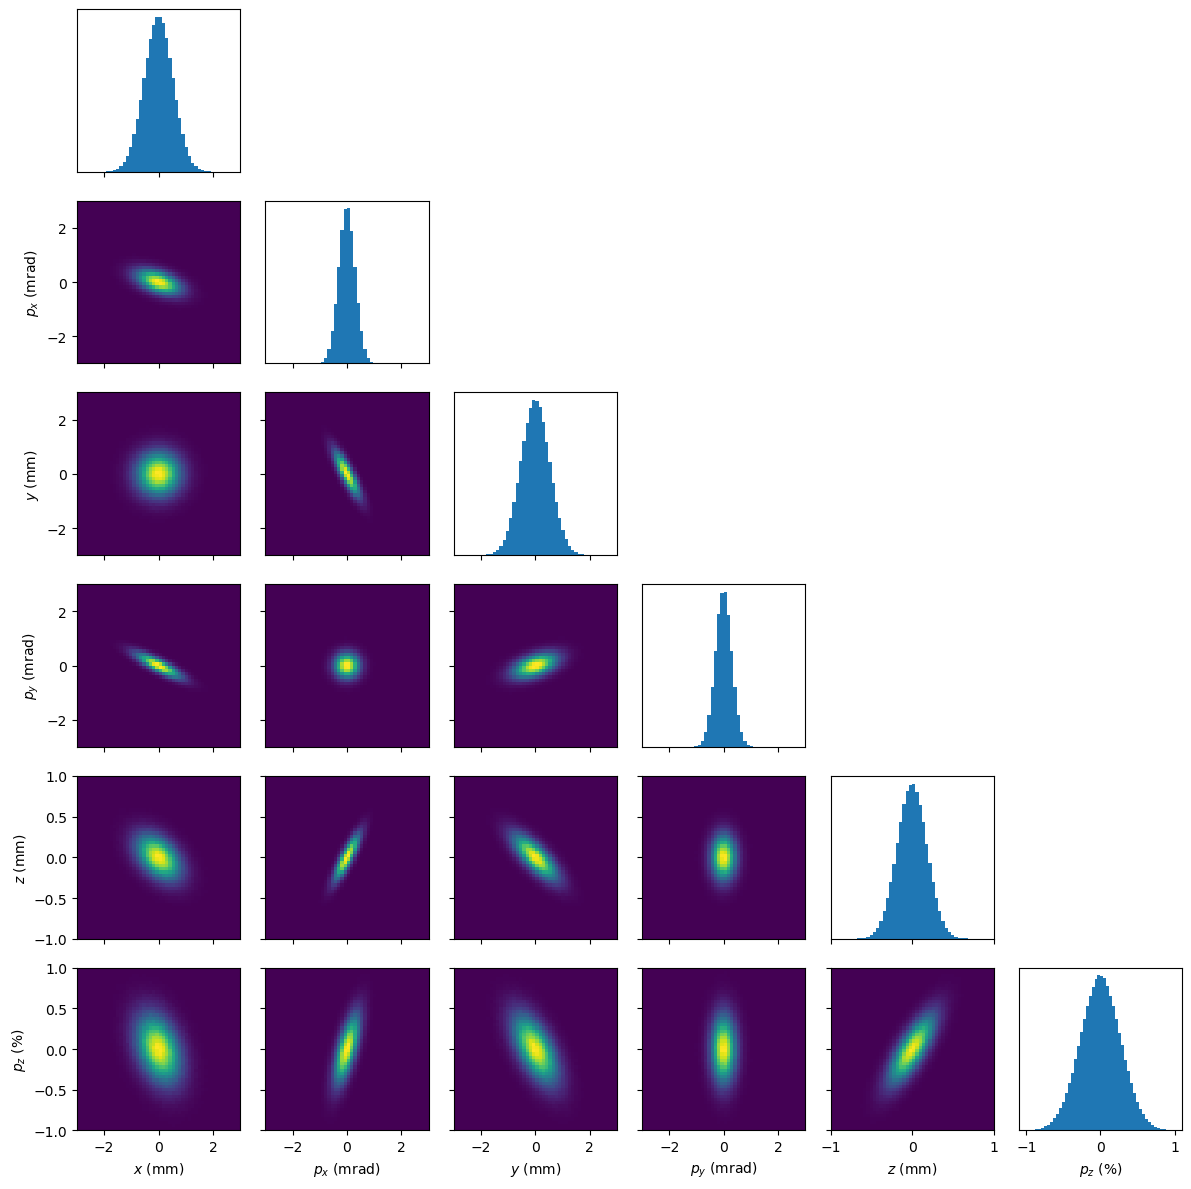

In [3]:
#plot gt beam
lims = np.array([[-15e-3, 15e-3],
                 [-15e-3, 15e-3],
                 [-15e-3, 15e-3],
                 [-15e-3, 15e-3],
                 [-5e-3, 5e-3],
                 [-5e-2, 5e-2]]) * 0.2
fig, ax = plot_projections(
    gt_beam.numpy_particles(),
    custom_lims = lims,
    background = 0
)
plt.show()

## Define diagnostics lattice parameters

In [4]:
# triplet params obtained from triplet-opt.ipynb
k1 =            -24.868402
k2 =             26.179029
k3 =            -26.782126

In [5]:
# diagnostic beamline:
lattice = quadlet_tdc_bend(p0c=p0c, dipole_on=False)
lattice.elements[0].K1.data = torch.tensor(k1)
lattice.elements[2].K1.data = torch.tensor(k2)
lattice.elements[4].K1.data = torch.tensor(k3)

# Scan over quad strength, tdc on/off and dipole on/off
scan_ids = [6, 8, 10] 
n_ks = 5
ks = torch.linspace(-3, 3, n_ks) # quad ks
vs = torch.tensor([0, 3e6]) # TDC off/on
gs = torch.tensor([-2.22e-16, -20.0*PI/180.0/0.365]) # dipole off/on
train_params = torch.stack(torch.meshgrid(ks, vs, gs, indexing='ij'))
#print(train_params.shape)
#print(train_params.unsqueeze(-1).shape)

# create diagnostic screen: 
bins = torch.linspace(-5, 5, 200) * 1e-3
bandwidth = (bins[1]-bins[0]) / 2
screen = ImageDiagnostic(bins, bins, bandwidth)

## Complete 3D scan training data

## 'T' scan training data

In [6]:
# generate and save train and test datasets
train_dset_t_scan = run_awa_t_scan(
    gt_beam, 
    lattice,
    screen, 
    ks, vs, gs,
    ids = scan_ids,
    save_as = os.path.join(save_dir, 't_scan_train.dset')
    )

print(train_dset_t_scan.params.shape)
print(train_dset_t_scan.images.shape)

torch.Size([8, 3, 1])
tensor([[-3.0000e+00,  0.0000e+00, -2.2200e-16],
        [-1.5000e+00,  0.0000e+00, -2.2200e-16],
        [ 0.0000e+00,  0.0000e+00, -2.2200e-16],
        [ 1.5000e+00,  0.0000e+00, -2.2200e-16],
        [ 3.0000e+00,  0.0000e+00, -2.2200e-16],
        [ 0.0000e+00,  0.0000e+00, -9.5634e-01],
        [ 0.0000e+00,  3.0000e+06, -2.2200e-16],
        [ 0.0000e+00,  3.0000e+06, -9.5634e-01]])
dataset saved as 'data/gaussian_beam/t_scan/t_scan_train.dset'
torch.Size([8, 3, 1])
torch.Size([8, 1, 200, 200])


/global/homes/r/rroussel/.conda/envs/ps-reconstruction/lib/python3.10/site-packages/torch/functional.py:504: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at /home/conda/feedstock_root/build_artifacts/pytorch-recipe_1694463969407/work/aten/src/ATen/native/TensorShape.cpp:3483.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


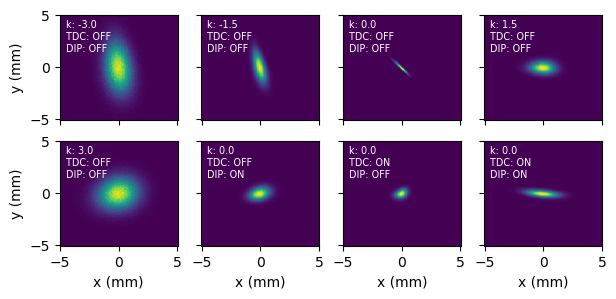

In [7]:
fig, ax = plt.subplots(2,4,sharex="all",sharey="all",figsize=(7,3))
xx = torch.meshgrid(bins*1e3, bins*1e3)
params = train_dset_t_scan.params.squeeze()

for i, ele in enumerate(ax.flatten()):
    ele.pcolor(xx[0].numpy(),xx[1].numpy(), train_dset_t_scan.images[i, 0].numpy(), 
               rasterized=True)#,vmax=1.1*torch.max(train_dset_t_scan.images))
    dip = "ON" if abs(params[i,2]) > 0.1 else "OFF"
    tdc = "ON" if params[i,1] > 0.1 else "OFF"
    ele.text(
        0.05,0.95,
        f"k: {params[i][0]}\nTDC: {tdc}\nDIP: {dip}",
        fontdict={"color":"white","size":"x-small"},
        transform=ele.transAxes,
        va="top",
        ha="left"
    )
for a in ax[-1,:]:
    a.set_xlabel("x (mm)")

for a in ax[:,0]:
    a.set_ylabel("y (mm)")

In [8]:
%%time

# training
pred_beam_3d_scan_10_000, model = train_3d_scan(
    train_dset_t_scan, 
    lattice, 
    p0c, 
    screen,
    ids = scan_ids,
    n_epochs = 3_000, 
    n_particles = 100_000, 
    device = 'cuda:0',
    save_dir = save_dir,
    distribution_dump_frequency=500,
    distribution_dump_n_particles=1_000_000,
    )

Using device: cuda:0
0 tensor(4.6439e-05, device='cuda:0', grad_fn=<MeanBackward0>)
100 tensor(3.1514e-06, device='cuda:0', grad_fn=<MeanBackward0>)
200 tensor(2.3568e-06, device='cuda:0', grad_fn=<MeanBackward0>)
300 tensor(2.1942e-06, device='cuda:0', grad_fn=<MeanBackward0>)
400 tensor(2.2169e-06, device='cuda:0', grad_fn=<MeanBackward0>)
500 tensor(2.3005e-06, device='cuda:0', grad_fn=<MeanBackward0>)
600 tensor(2.1233e-06, device='cuda:0', grad_fn=<MeanBackward0>)
700 tensor(2.1532e-06, device='cuda:0', grad_fn=<MeanBackward0>)
800 tensor(2.1369e-06, device='cuda:0', grad_fn=<MeanBackward0>)
900 tensor(2.1625e-06, device='cuda:0', grad_fn=<MeanBackward0>)
1000 tensor(2.2107e-06, device='cuda:0', grad_fn=<MeanBackward0>)
1100 tensor(2.0692e-06, device='cuda:0', grad_fn=<MeanBackward0>)
1200 tensor(2.0637e-06, device='cuda:0', grad_fn=<MeanBackward0>)
1300 tensor(1.9938e-06, device='cuda:0', grad_fn=<MeanBackward0>)
1400 tensor(2.0964e-06, device='cuda:0', grad_fn=<MeanBackward0>)
1

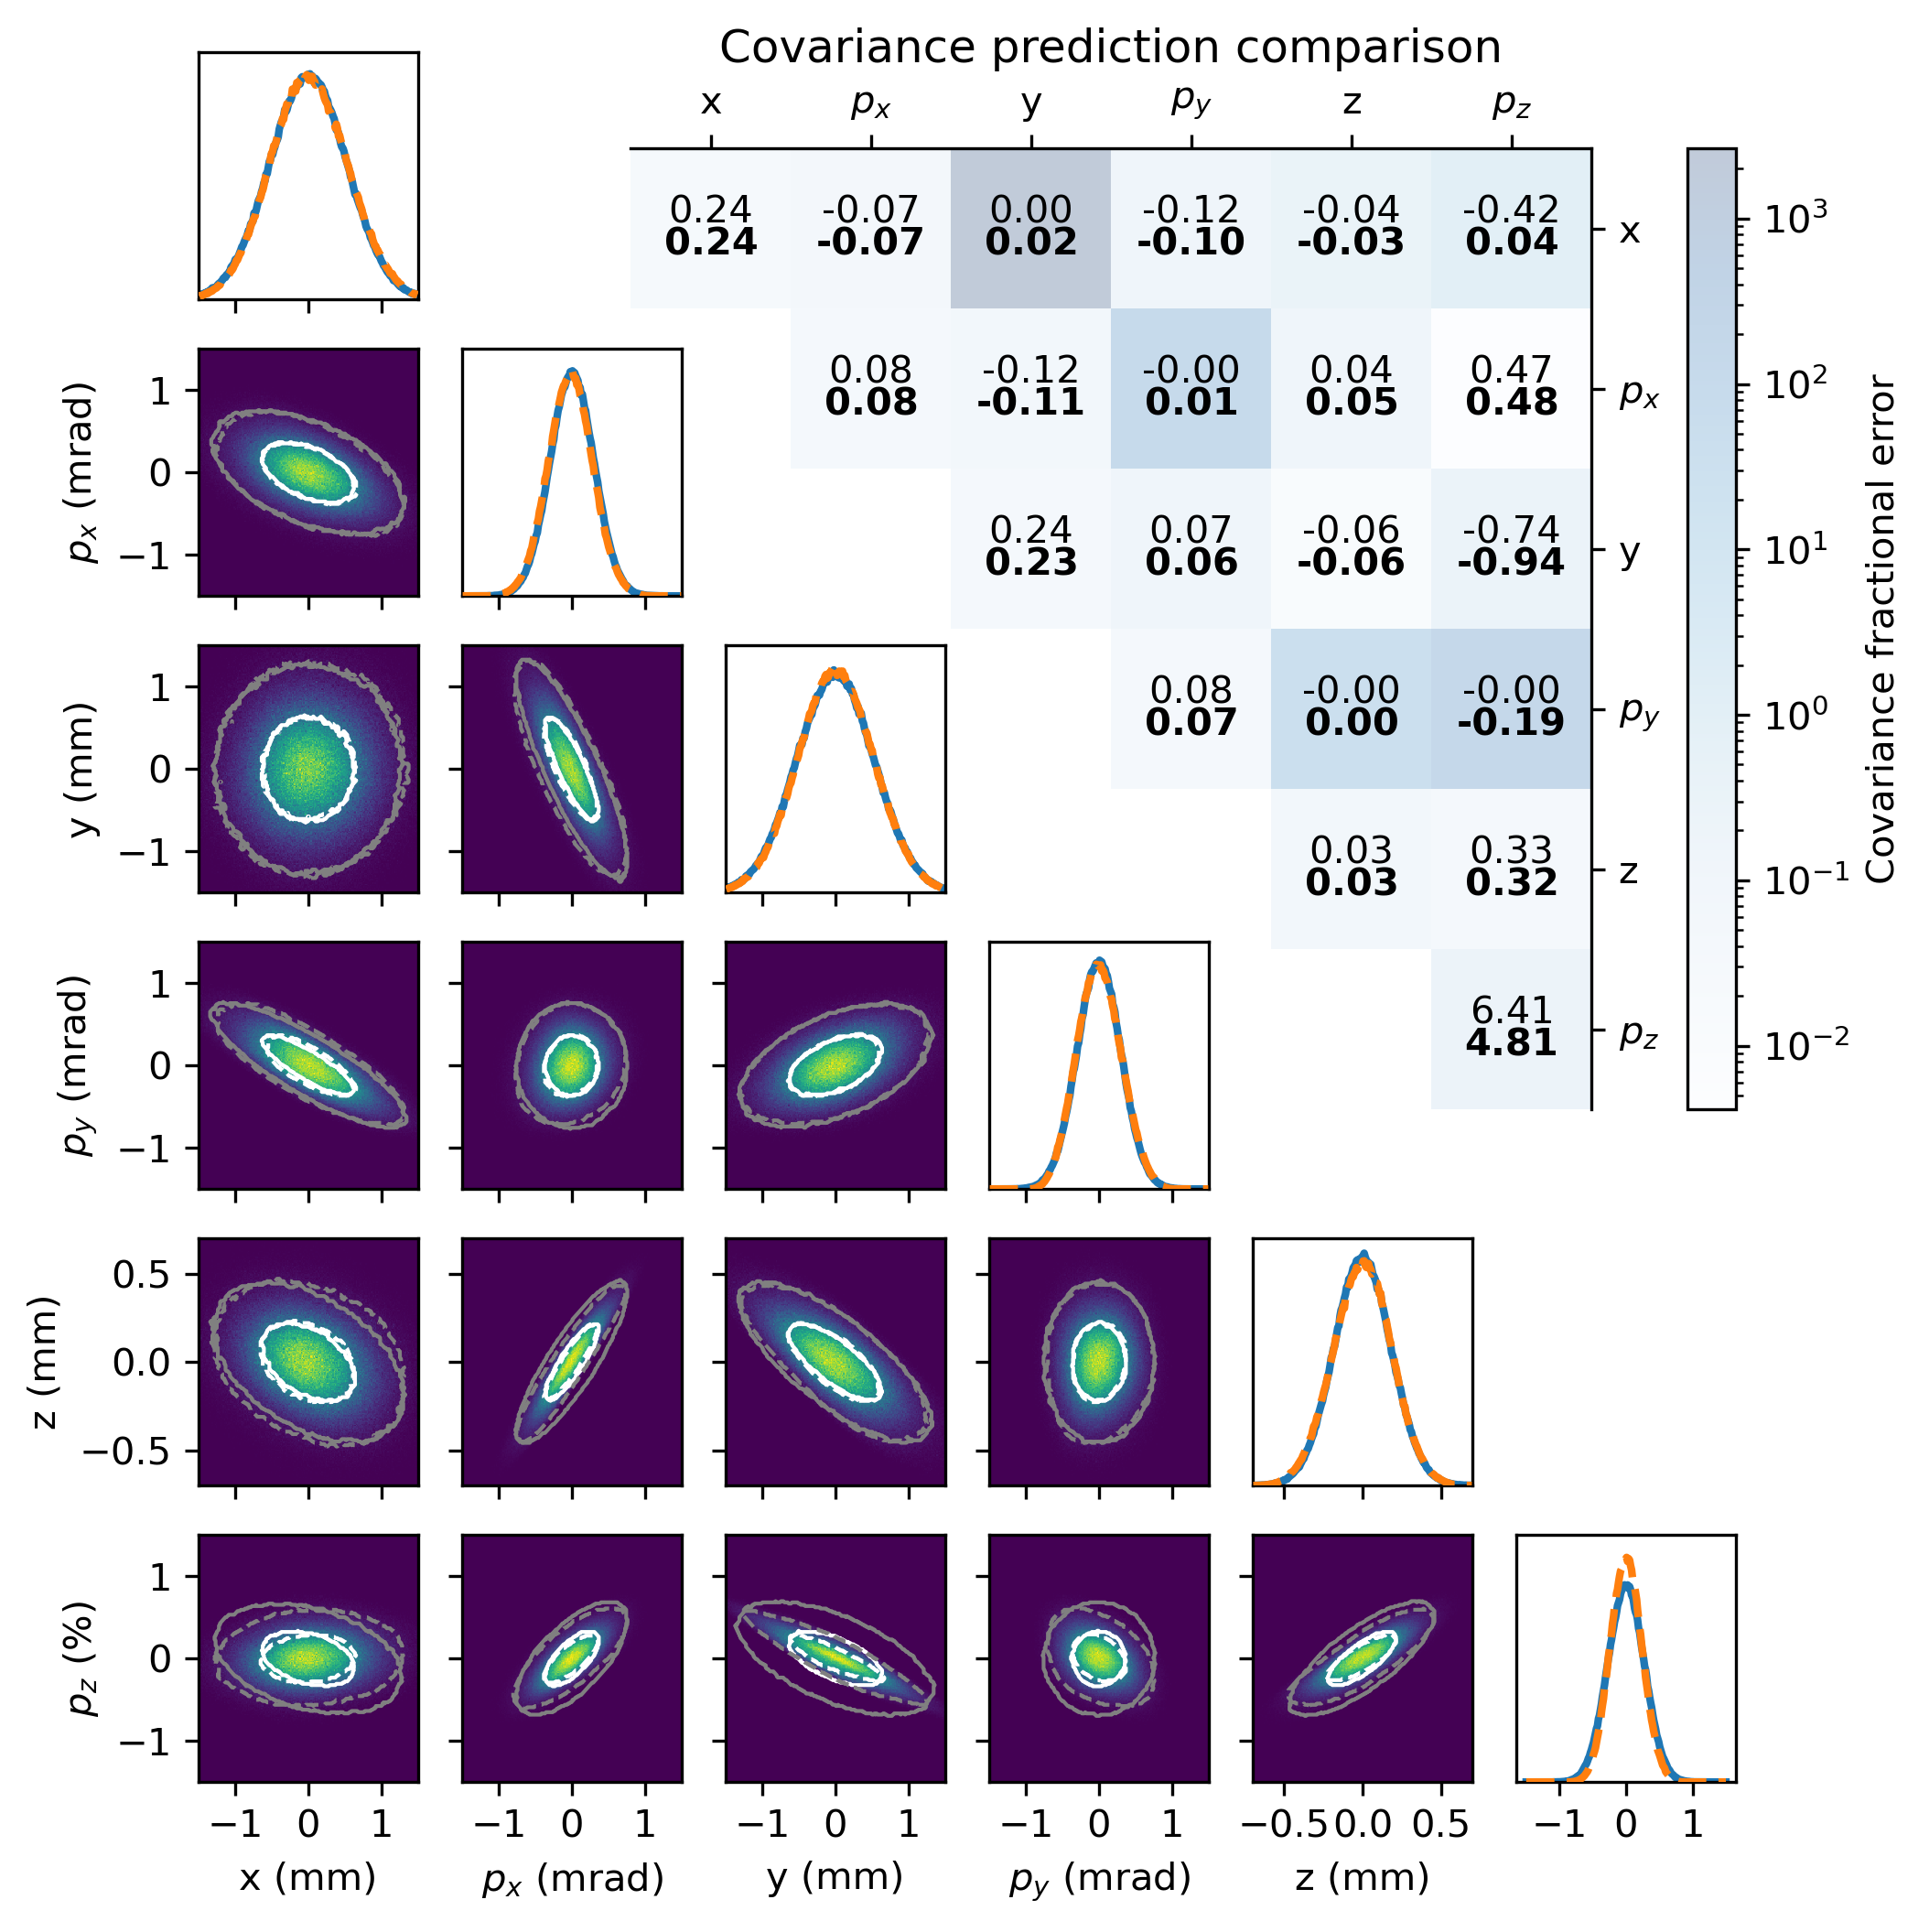

In [9]:
import torch
from stats import plot_projections_with_contours, show_cov_stats, plot_prab_figure
import os

lims = np.array([[-15, 15],
                 [-15, 15],
                 [-15, 15],
                 [-15, 15],
                 [-7, 7],
                 [-15, 15]])*0.1

recn_dist = torch.load(os.path.join(save_dir, 'dist_3000.pt'))
recn_dist.data = recn_dist.data
fig = plot_prab_figure(
    recn_dist,
    gt_beam,
    n_bins=200,
    contour_percentiles = [50, 95],
    custom_lims=lims,
)